In [115]:
import numpy as np
import pandas as pd
import xgboost as xgb
import pickle

# params
runmode = 'personal'
n_fold = 5
# xvars = ['quality','dow', 'act_prev','daytype','stress_prev','energy_prev','focus_prev','mood_prev','quality_prev','mood_prev2','quality_prev2','mood_prev3','quality_prev3']
# xvars = ['quality','quality_prev','mood_prev','quality_prev2','mood_prev2']
xvars = ['quality','quality_prev','mood_prev','quality_prev2','mood_prev2','act_prev','stress_prev','daytype']
yvars = ['mood']

# read data
with open('data.dat') as f:
    data, subjects = pickle.load(f)
f.close()

# data = data[:10]

# personal analysis

if runmode=='personal':

    r2_train = np.array([])
    r2_test = np.array([])

    for i in range(len(data)):


        data[i] = data[i][xvars+yvars]
        data[i] = data[i].dropna()
        data[i] = data[i].reset_index(drop=True)

        if data[i].shape[0]<20:
            print 'skipping subject '+subjects[i]
            continue

        x = data[i][xvars]
        y = data[i][yvars]

        fold_size = np.floor(data[i].shape[0]/float(n_fold))

        r2_row_train = np.zeros([1,n_fold])
        r2_row_test = np.zeros([1,n_fold])

        for j in range(n_fold):

            xtest = x.loc[j*fold_size:(j+1)*fold_size-1,:]
            xtest = xtest.reset_index(drop=True)
            ytest = y.loc[j*fold_size:(j+1)*fold_size-1]
            ytest = ytest.reset_index(drop=True)

            xtrain = x.loc[0:j*fold_size-1,:]
            xtrain = pd.concat([xtrain, x.loc[(j+1)*fold_size:,:]], axis=0)
            xtrain = xtrain.reset_index(drop=True)

            ytrain = y.loc[0:j*fold_size-1]
            ytrain = pd.concat([ytrain, y.loc[(j+1)*fold_size:]], axis=0)
            ytrain = ytrain.reset_index(drop=True)

            if np.var(np.array(ytrain))==0:
                print 'skipping fold due to no variation in outcome'
                r2_row_train[0,j] = np.nan
                r2_row_test[0,j] = np.nan
                continue

            gbm = xgb.XGBRegressor(max_depth=3, learning_rate=0.05, n_estimators=200, silent=True, objective='reg:linear', nthread=-1,\
                             gamma=0, min_child_weight=1, max_delta_step=0, subsample=0.25, colsample_bytree=0.25, colsample_bylevel=1,\
                             reg_alpha=0.7, reg_lambda=1, scale_pos_weight=1, base_score=0.5, seed=0, missing=None)

            gbm.fit(xtrain, ytrain, eval_set=[(xtrain,ytrain),(xtest, ytest)], eval_metric='rmse', verbose=False)

            # training performance
            ypred_train = gbm.predict(xtrain).reshape(xtrain.shape[0],1)
            r2_row_train[0,j] = 1 - (np.sum(np.power(ypred_train-np.array(ytrain),2))/\
                                     np.sum(np.power(np.mean(np.array(ytrain))-np.array(ytrain),2)))

            # test performance
            ypred_test = gbm.predict(xtest).reshape(xtest.shape[0],1)
            r2_row_test[0,j] = 1 - (np.sum(np.power(ypred_test-np.array(ytest),2))/\
                                    np.sum(np.power(np.mean(np.array(ytrain))-np.array(ytest),2)))

        if r2_test.size==0:
            r2_train = r2_row_train
            r2_test = r2_row_test
        else:
            r2_train = np.append(r2_train, r2_row_train, axis=0)
            r2_test = np.append(r2_test, r2_row_test, axis=0)
        

elif runmode=='mixed':

    xvars += ['subject']

    r2_train = np.array([])
    r2_test = np.array([])
    
    # mixed analysis
    for i in range(len(data)):
        data[i]['subject'] = pd.Series(np.repeat(i,data[i].shape[0],axis=0), index=data[i].index, dtype=float)
    
    # concatenatig into a single dataframe
    data_all = pd.concat(data, axis=0)
    data_all = data_all.reset_index(drop=True)
    
    # remove nans
    data_all = data_all.dropna()
    data_all = data_all.reset_index(drop=True)

    x = data_all[xvars]
    y = data_all[yvars]

    fold_size = np.floor(data_all.shape[0]/float(n_fold))

    r2_row_train = np.zeros([1,n_fold])
    r2_row_test = np.zeros([1,n_fold])

    for j in range(n_fold):

        xtest = x.loc[j*fold_size:(j+1)*fold_size-1,:]
        xtest = xtest.reset_index(drop=True)
        ytest = y.loc[j*fold_size:(j+1)*fold_size-1]
        ytest = ytest.reset_index(drop=True)

        xtrain = x.loc[0:j*fold_size-1,:]
        xtrain = pd.concat([xtrain, x.loc[(j+1)*fold_size:,:]], axis=0)
        xtrain = xtrain.reset_index(drop=True)

        ytrain = y.loc[0:j*fold_size-1]
        ytrain = pd.concat([ytrain, y.loc[(j+1)*fold_size:]], axis=0)
        ytrain = ytrain.reset_index(drop=True)

        if np.var(np.array(ytrain))==0:
            print 'skipping fold due to no variation in outcome'
            r2_row_train[0,j] = np.nan
            r2_row_test[0,j] = np.nan
            continue

        gbm = xgb.XGBRegressor(max_depth=3, learning_rate=0.05, n_estimators=200, silent=True, objective='reg:linear', nthread=-1,\
                         gamma=0, min_child_weight=1, max_delta_step=0, subsample=0.25, colsample_bytree=0.25, colsample_bylevel=1,\
                         reg_alpha=0.7, reg_lambda=1, scale_pos_weight=1, base_score=0.5, seed=0, missing=None)

        gbm.fit(xtrain, ytrain, eval_set=[(xtrain,ytrain),(xtest, ytest)], eval_metric='rmse', verbose=False)

        # training performance
        ypred_train = gbm.predict(xtrain).reshape(xtrain.shape[0],1)
        r2_row_train[0,j] = 1 - (np.sum(np.power(ypred_train-np.array(ytrain),2))/\
                                 np.sum(np.power(np.mean(np.array(ytrain))-np.array(ytrain),2)))

        # test performance
        ypred_test = gbm.predict(xtest).reshape(xtest.shape[0],1)
        r2_row_test[0,j] = 1 - (np.sum(np.power(ypred_test-np.array(ytest),2))/\
                                np.sum(np.power(np.mean(np.array(ytrain))-np.array(ytest),2)))

    if r2_test.size==0:
        r2_train = r2_row_train
        r2_test = r2_row_test
    else:
        r2_train = np.append(r2_train, r2_row_train, axis=0)
        r2_test = np.append(r2_test, r2_row_test, axis=0)


(array([[ 2.52300858],
        [ 2.55066442],
        [ 2.72406912],
        ..., 
        [ 7.15827227],
        [ 7.21346474],
        [ 7.29209614]], dtype=float32),           mood
 0     2.500000
 1     2.500000
 2     1.333333
 3     0.666667
 4     0.666667
 5     1.000000
 6     0.666667
 7     1.333333
 8     1.333333
 9     1.666667
 10    0.666667
 11    1.333333
 12    2.000000
 13    0.666667
 14    0.333333
 15    0.000000
 16    0.333333
 17    0.000000
 18    0.666667
 19    2.333333
 20    2.000000
 21    0.666667
 22    0.666667
 23    2.666667
 24    7.333333
 25    7.000000
 26    7.666667
 27    7.333333
 28    7.666667
 29    7.000000
 ...        ...
 1062  7.333333
 1063  6.333333
 1064  7.333333
 1065  8.000000
 1066  7.250000
 1067  6.666667
 1068  6.666667
 1069  7.000000
 1070  7.666667
 1071  7.500000
 1072  7.500000
 1073  7.333333
 1074  7.666667
 1075  8.000000
 1076  8.000000
 1077  8.000000
 1078  7.666667
 1079  8.000000
 1080  8.000000
 1081  7.333333


## Predict Mood from Sleep Quality

training mean R2 = 0.273877323144
test mean R2 = -0.130447550566


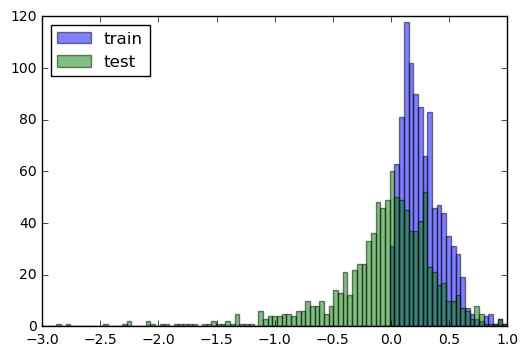

In [65]:
import matplotlib.pyplot as plt
%matplotlib inline

print 'training mean R2 = {}'.format(np.nanmean(r2_train))
print 'test mean R2 = {}'.format(np.nanmean(r2_test))

bins = np.linspace(-3, 1, 100)
plt.hist(r2_train.flatten(), bins, alpha=0.5, label='train');
plt.hist(r2_test.flatten(), bins, alpha=0.5, label='test');
plt.legend(loc='upper left')

## Add Mood(t-1) and Quality(t-1)

training mean R2 = 0.851012876406
test mean R2 = -0.606042365809


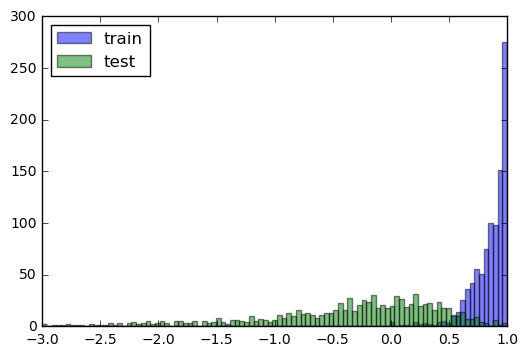

In [82]:
import matplotlib.pyplot as plt
%matplotlib inline

print 'training mean R2 = {}'.format(np.nanmean(r2_train))
print 'test mean R2 = {}'.format(np.nanmean(r2_test))

bins = np.linspace(-3, 1, 100)
plt.hist(r2_train.flatten()[~np.isnan(r2_train.flatten())], bins, alpha=0.5, label='train');
plt.hist(r2_test.flatten()[~np.isnan(r2_test.flatten())], bins, alpha=0.5, label='test');
plt.legend(loc='upper left')

## Add Mood(t-2) and Quality(t-2)

training mean R2 = 0.960386072731
test mean R2 = -0.708666004074


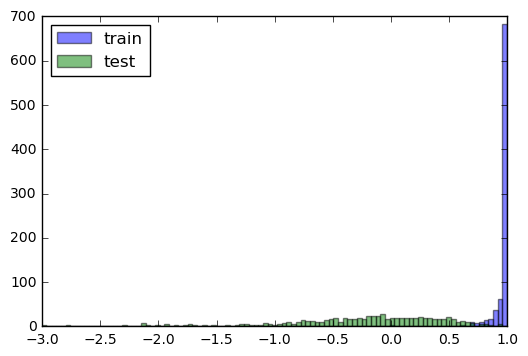

In [84]:
import matplotlib.pyplot as plt
%matplotlib inline

print 'training mean R2 = {}'.format(np.nanmean(r2_train))
print 'test mean R2 = {}'.format(np.nanmean(r2_test))

bins = np.linspace(-3, 1, 100)
plt.hist(r2_train.flatten()[~np.isnan(r2_train.flatten())], bins, alpha=0.5, label='train');
plt.hist(r2_test.flatten()[~np.isnan(r2_test.flatten())], bins, alpha=0.5, label='test');
plt.legend(loc='upper left')

## Add Subsampling (0.5)

training mean R2 = 0.836777285318
test mean R2 = -0.241903556178


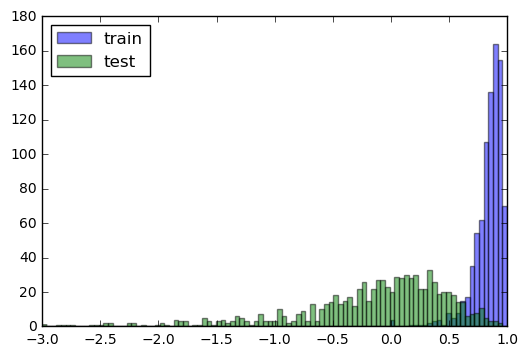

In [88]:
import matplotlib.pyplot as plt
%matplotlib inline

print 'training mean R2 = {}'.format(np.nanmean(r2_train))
print 'test mean R2 = {}'.format(np.nanmean(r2_test))

bins = np.linspace(-3, 1, 100)
plt.hist(r2_train.flatten()[~np.isnan(r2_train.flatten())], bins, alpha=0.5, label='train');
plt.hist(r2_test.flatten()[~np.isnan(r2_test.flatten())], bins, alpha=0.5, label='test');
plt.legend(loc='upper left')

## Add L1 Regularization (alpha=0.7)

training mean R2 = 0.662334189318
test mean R2 = -0.178992945916


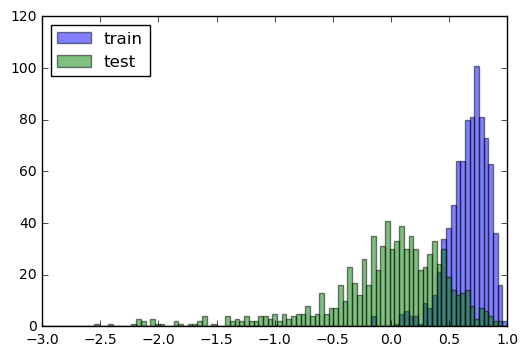

In [98]:
import matplotlib.pyplot as plt
%matplotlib inline

print 'training mean R2 = {}'.format(np.nanmean(r2_train))
print 'test mean R2 = {}'.format(np.nanmean(r2_test))

bins = np.linspace(-3, 1, 100)
plt.hist(r2_train.flatten()[~np.isnan(r2_train.flatten())], bins, alpha=0.5, label='train');
plt.hist(r2_test.flatten()[~np.isnan(r2_test.flatten())], bins, alpha=0.5, label='test');
plt.legend(loc='upper left')

## Add Other Confounds

training mean R2 = 0.787905586026
test mean R2 = -0.240748190836


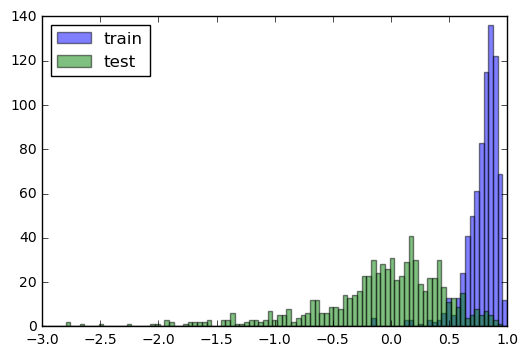

In [100]:
import matplotlib.pyplot as plt
%matplotlib inline

print 'training mean R2 = {}'.format(np.nanmean(r2_train))
print 'test mean R2 = {}'.format(np.nanmean(r2_test))

bins = np.linspace(-3, 1, 100)
plt.hist(r2_train.flatten()[~np.isnan(r2_train.flatten())], bins, alpha=0.5, label='train');
plt.hist(r2_test.flatten()[~np.isnan(r2_test.flatten())], bins, alpha=0.5, label='test');
plt.legend(loc='upper left')

## Heavier Regularization (Subsampling = 0.25)

training mean R2 = 0.530708933922
test mean R2 = -0.342541582002


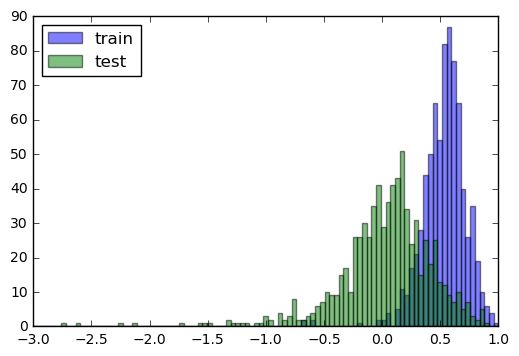

In [102]:
import matplotlib.pyplot as plt
%matplotlib inline

print 'training mean R2 = {}'.format(np.nanmean(r2_train))
print 'test mean R2 = {}'.format(np.nanmean(r2_test))

bins = np.linspace(-3, 1, 100)
plt.hist(r2_train.flatten()[~np.isnan(r2_train.flatten())], bins, alpha=0.5, label='train');
plt.hist(r2_test.flatten()[~np.isnan(r2_test.flatten())], bins, alpha=0.5, label='test');
plt.legend(loc='upper left')